In [1]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput
from utils3d import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
sys.path.append("BFCalc")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lpin0002/Desktop/DMPipe/utils.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils3d.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils3d.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


In [16]:
lonmeshtrue, log10emeshtrue, latmeshtrue = np.meshgrid(offsetaxistrue, log10eaxistrue, offsetaxistrue)

logjacobtrue = makelogjacob(log10eaxistrue)    

logbkgpriorvalues = np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue))

logbkgpriorvalues = logbkgpriorvalues - special.logsumexp(logbkgpriorvalues.T+logjacobtrue).T

logbkgpriorvalues.shape

/Users/lpin0002/Desktop/DMPipe/utils3d.py:130: RuntimeWarning: divide by zero encountered in log
  return np.log(bkgfull.evaluate(energy=10**logeval*u.TeV, fov_lon=np.abs(lon)*2*u.deg, fov_lat=np.abs(lat)*2*u.deg).value)


(28, 40, 40)

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_53181/4006849877.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_53181/4006849877.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


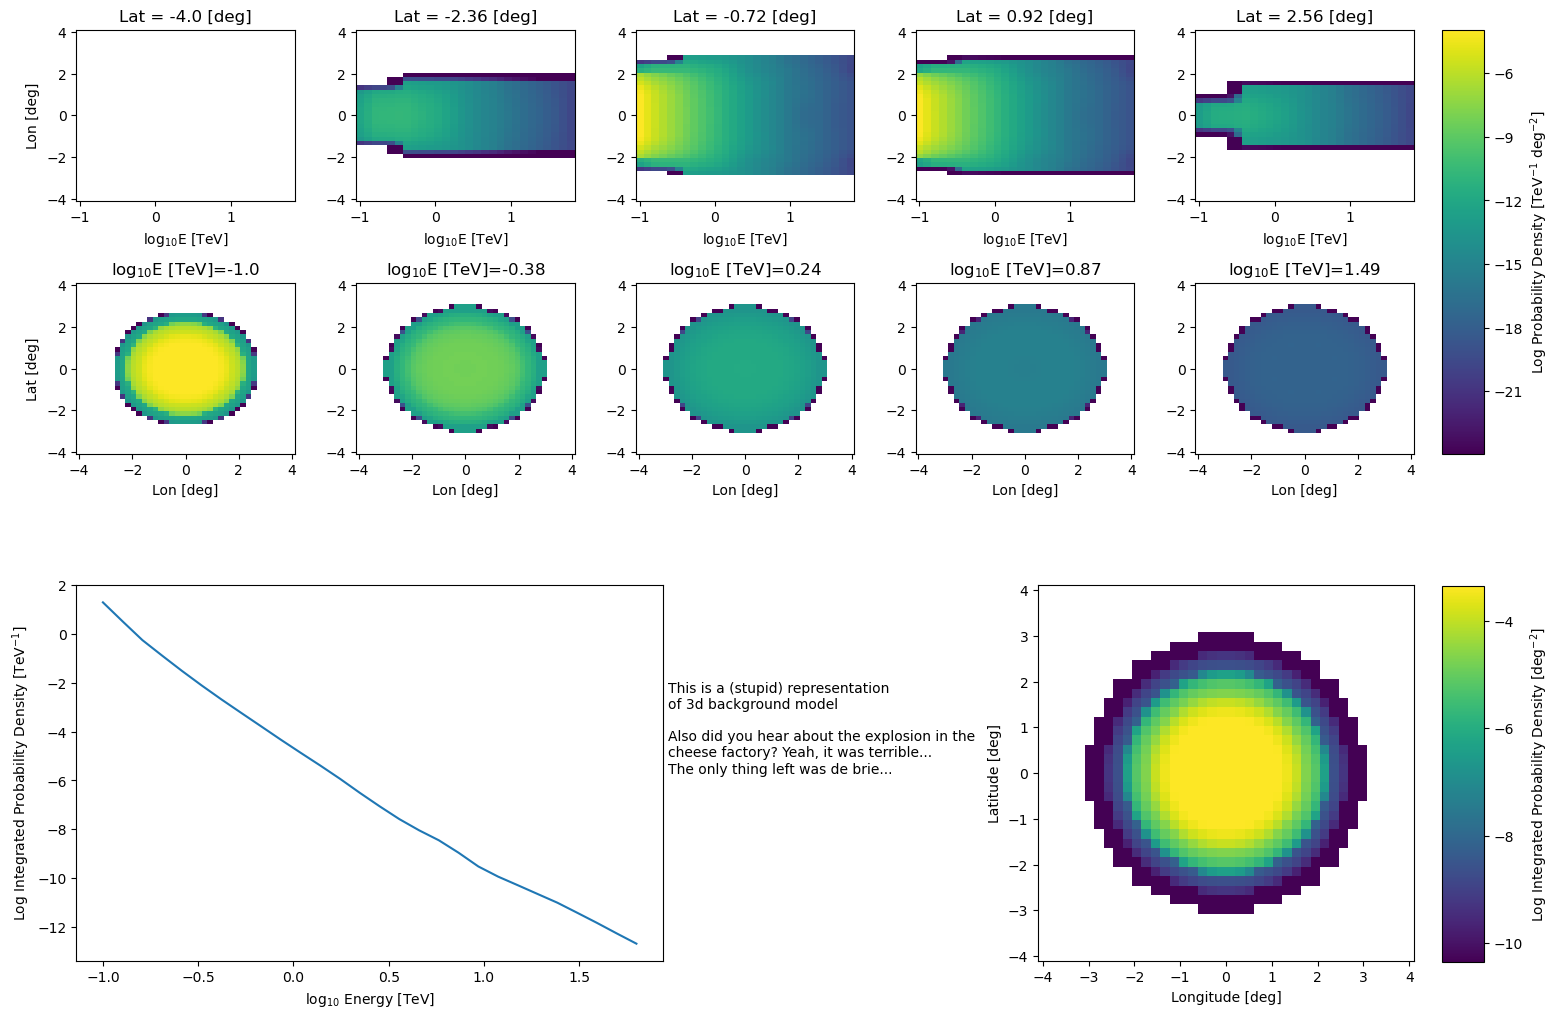

In [3]:
fig,axs = plt.subplots(4,5, figsize=(14,10))


maxval = np.max(logbkgpriorvalues)


offsetconverter = int(np.round(offsetaxistrue.shape[0]/5))
axs[0,0].pcolormesh(log10eaxistrue, offsetaxistrue, logbkgpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(5):
    axs[0,index].pcolormesh(log10eaxistrue, offsetaxistrue, logbkgpriorvalues[:,:,index*offsetconverter].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(offsetaxistrue[index*offsetconverter],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = int(np.round(log10eaxistrue.shape[0]/5))
axs[1,0].pcolormesh(offsetaxistrue, offsetaxistrue, logbkgpriorvalues[0,:,:], vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[0*logeconverter],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,5):
    pcol = axs[1,jndex].pcolormesh(offsetaxistrue, offsetaxistrue, logbkgpriorvalues[jndex*logeconverter,:,:], vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[jndex*logeconverter],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logbkgpriorvalues,axis=(1,2)))
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,7,11)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d background model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logbkgpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(offsetaxistrue, offsetaxistrue, integratedvals, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20),np.round(maxval), 3))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 2))
# fig.tight_layout(pad=5.0)
plt.show()

In [23]:
signalfunc = setup_full_fake_signal_dist(1.0, darkmatterdoubleinput)

In [24]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, offsetaxistrue, offsetaxistrue)

logsigpriorvalues = signalfunc(log10emeshtrue, lonmeshtrue,latmeshtrue)

logsigpriorvalues = (logsigpriorvalues - special.logsumexp(logsigpriorvalues+logjacobtrue)).T
logsigpriorvalues.shape

(40, 40)
(28,)
(40, 40, 28)


/Users/lpin0002/Desktop/DMPipe/BFCalc/createspectragrids.py:107: RuntimeWarning: divide by zero encountered in log
  return np.log(twodinterpolationfunc(logmDM, logenergy-logmDM))


(28, 40, 40)

In [25]:
lonmeshtrue[:,0,0]

array([-4.        , -3.79487179, -3.58974359, -3.38461538, -3.17948718,
       -2.97435897, -2.76923077, -2.56410256, -2.35897436, -2.15384615,
       -1.94871795, -1.74358974, -1.53846154, -1.33333333, -1.12820513,
       -0.92307692, -0.71794872, -0.51282051, -0.30769231, -0.1025641 ,
        0.1025641 ,  0.30769231,  0.51282051,  0.71794872,  0.92307692,
        1.12820513,  1.33333333,  1.53846154,  1.74358974,  1.94871795,
        2.15384615,  2.35897436,  2.56410256,  2.76923077,  2.97435897,
        3.17948718,  3.38461538,  3.58974359,  3.79487179,  4.        ])

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_53181/1778920640.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_53181/1778920640.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,7,11)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_53181/1778920640.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


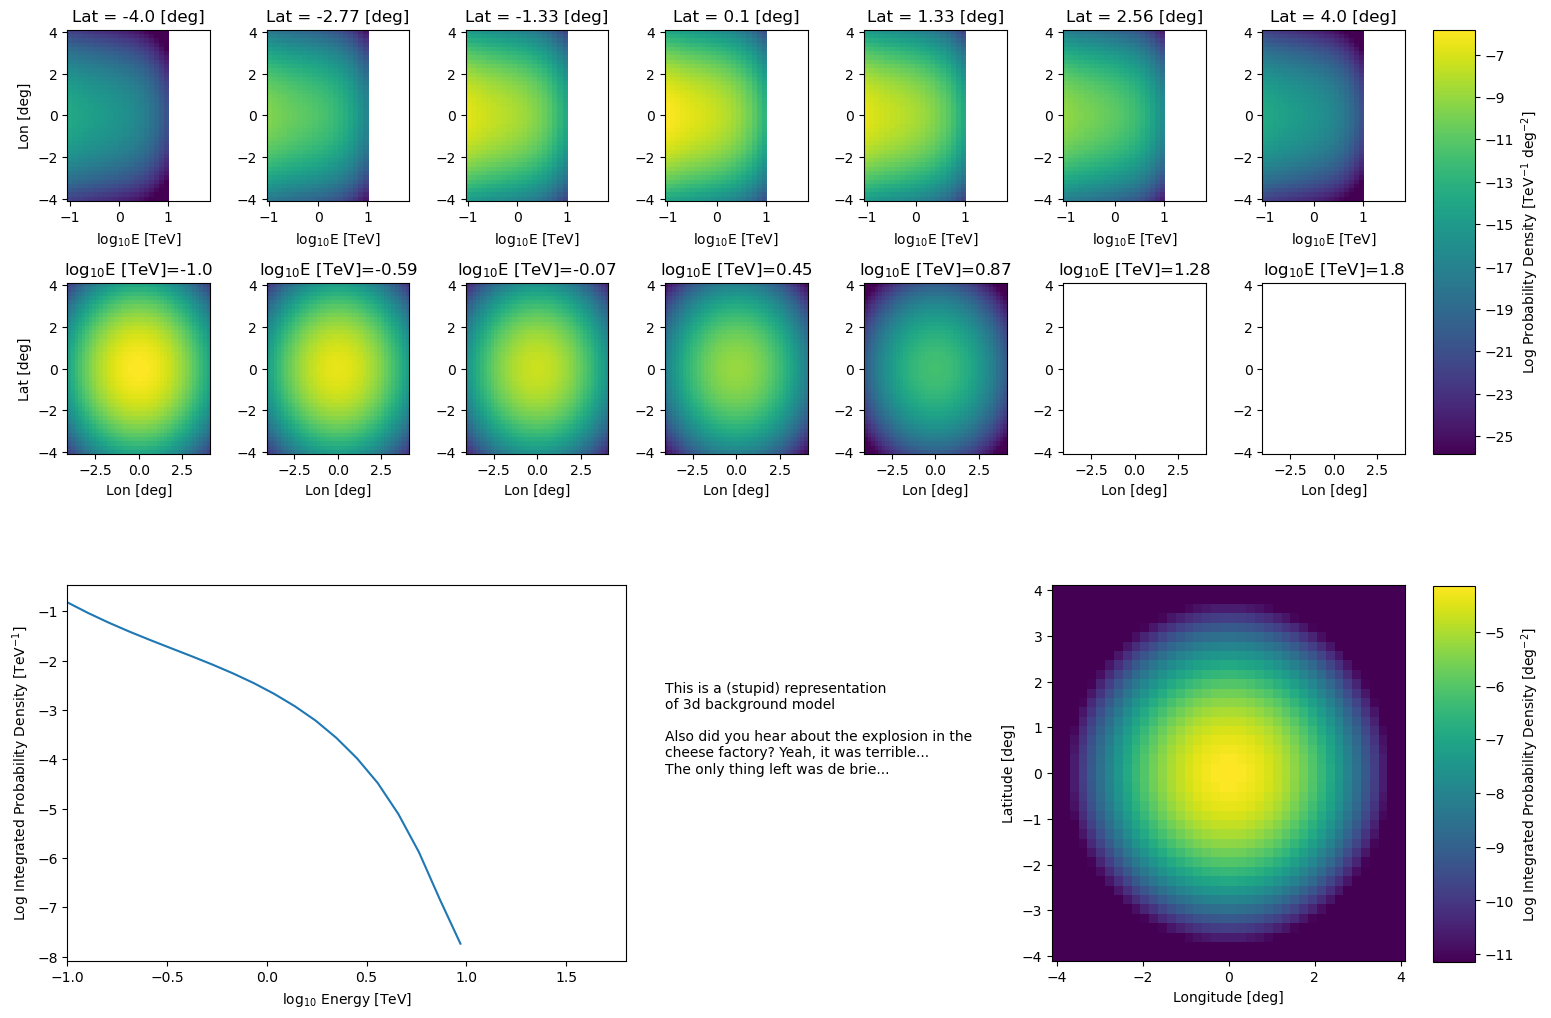

In [50]:
numslices = 7
fig,axs = plt.subplots(4,numslices, figsize=(14,10))


maxval = np.max(logsigpriorvalues)

offsetconverter = np.round(np.linspace(0, offsetaxistrue.shape[0]-1,numslices))


axs[0,0].pcolormesh(log10eaxistrue, offsetaxistrue, logsigpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(numslices):
    axs[0,index].pcolormesh(log10eaxistrue, offsetaxistrue, logsigpriorvalues[:,:,int(offsetconverter[index])].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(offsetaxistrue[int(offsetconverter[index])],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = np.round(np.linspace(0, log10eaxistrue.shape[0]-1,numslices))

axs[1,0].pcolormesh(offsetaxistrue, offsetaxistrue, logsigpriorvalues[0,:,:], vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[0])],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,numslices):
    pcol = axs[1,jndex].pcolormesh(offsetaxistrue, offsetaxistrue, logsigpriorvalues[int(logeconverter[jndex]),:,:], vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[jndex])],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logsigpriorvalues,axis=(1,2)))
plt.xlim([log10eaxistrue[0],log10eaxistrue[-1]])
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,7,11)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d background model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logsigpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(offsetaxistrue, offsetaxistrue, integratedvals, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20)-1,np.round(maxval)+1, 2))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 1))
# fig.tight_layout(pad=5.0)
plt.show()